In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
sys.path.append('../neurokin/')
from neurokin.utils.neural import processing, importing
from neurokin.utils.experiments import neural_states_helper, neural_correlates_plot, spider_factory
from neurokin.locomotion_states import NeuralCorrelatesStates
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import arviz as az
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
experiment_path = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural"
outputfolder = "./output_neural_correlates/"

NFFT = 2**12
NOV = int(NFFT/4)
TIME_CUTOFF = 1.5


pda = ["NWE00053", "NWE00054", "NWE00130", "NWE00160", "NWE00161", "NWE00162", "NWE00163", "NWE00164"]
skip_animals = ["NWE00053", "NWE00054", "NWE00052"]

CHANNEL_DICT = {"NWE00052": 6,
                "NWE00053": 1,
                "NWE00054": 1,
                "NWE00089": 1,
                "NWE00090": 1,
                "NWE00092": 1,
                "NWE00093": 1,
                "NWE00130": 3,
                "NWE00131": 2,
                "NWE00158": 3,
                "NWE00159": 3,
                "NWE00166": 3,
                "NWE00160": 3,
                "NWE00161": 3,
                "NWE00162": 3,
                "NWE00163": 3,
                "NWE00164": 3}

experiment_structure_path = experiment_path + "/experiment_structure.yaml"
conditions = ["baseline"]

In [3]:
data_structure = {}
input_folder = experiment_path
# Build the structure
days = [i for i in next(os.walk(input_folder))[1]]
for day in days:
    day_path = os.path.join(input_folder, day)
    animals = next(os.walk(day_path))[1]
    data_structure[day] = {}  # Initialize the day dictionary
    for animal in animals:
        animal_path = os.path.join(day_path, animal)
        runways = [f"{f.name}" for f in os.scandir(animal_path) if f.is_dir()]
        data_structure[day][animal] = {"baseline": runways}

# Write the structure to a YAML file
output_yaml = "./experiment_structure.yaml"
with open(output_yaml, "w") as yaml_file:
    yaml.dump(data_structure, yaml_file, default_flow_style=False)

In [4]:
ncs = NeuralCorrelatesStates(timeslice=TIME_CUTOFF,
                            experiment_structure_filepath=output_yaml,
                            skip_subjects=skip_animals)

In [5]:
ncs.create_events_dataset(experiment_path, verbose=False, file_starts_with="runway")

In [6]:
ncs.events_dataset

,date,subject,condition,run,event_gait,event_nlm_rest,event_nlm_active,event_fog_rest,event_fog_active
0,230303,NWE00090,baseline,05,"[[6.425, 9.23]]","[[6.4, 6.42]]","[[9.225, 9.85]]",[],[]
1,230303,NWE00090,baseline,08,"[[3.805, 7.625]]","[[0.005, 3.8]]","[[7.62, 12.45]]",[],[]
2,230303,NWE00090,baseline,11,[],"[[6.81, 14.54], [23.43, 38.57], [46.58, 60.91]...",[],"[[14.545, 23.435], [38.575, 46.585], [60.915, ...",[]
3,230303,NWE00090,baseline,04,[],"[[4.89, 45.82], [51.45, 70.145], [99.535, 115....",[],"[[45.825, 51.455], [70.15, 90.76], [90.76, 99....",[]
4,230303,NWE00090,baseline,01,"[[5.3, 7.44], [8.975, 11.8]]","[[5.085, 5.295]]","[[7.435, 8.97], [11.795, 11.82]]",[],[]
...,...,...,...,...,...,...,...,...,...
179,230504,NWE00166,baseline,09,"[[1.935, 3.725]]","[[1.88, 1.93]]","[[3.72, 3.725]]",[],[]
180,230504,NWE00166,baseline,06,"[[2.665, 4.4]]","[[2.54, 2.66]]","[[4.395, 4.43]]",[],[]
181,230504,NWE00166,baseline,03,"[[2.485, 4.24]]","[[2.25, 2.48]]","[[4.235, 4.26]]",[],[]
182,230504,NWE00166,baseline,10,"[[2.465, 4.17]]","[[2.315, 2.46]]","[[4.165, 4.395]]",[],[]


In [8]:
events_percentage = ncs.events_dataset.copy()
df= neural_states_helper.condense_distribution_event_types(df)
events_percentage = neural_states_helper.compute_events_percentage(df)

events_percentage["group"] = events_percentage["subject"].apply(lambda x: x in pda)
df["group"] = df["subject"].apply(lambda x: x in pda)
df.drop(["condition", "subject"], axis=1, inplace=True)

/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  durations[events_col] = durations[events_col].applymap(compute_duration).apply(compute_percentage, axis=1)


In [ ]:
state = "event_fog"

data1 = events_percentage[events_percentage["group"]==True][state]
data2 = events_percentage[events_percentage["group"]==False][state]
pval_fog = ttest_ind(data1, data2).pvalue

state = "event_nlm"

data1 = events_percentage[events_percentage["group"]==True][state]
data2 = events_percentage[events_percentage["group"]==False][state]
pval_nlm = ttest_ind(data1, data2).pvalue


state = "event_gait"

data1 = events_percentage[events_percentage["group"]==True][state]
data2 = events_percentage[events_percentage["group"]==False][state]
pval_gait = ttest_ind(data1, data2).pvalue

In [ ]:
pvals = np.asarray([pval_fog, pval_nlm, pval_gait])

In [ ]:
def bonferroni_holm(pvals, alpha):
    sortind = np.argsort(pvals)
    pvals = np.take(pvals, sortind)
    ntests = len(pvals)
    alphacSidak = 1 - np.power((1. - alpha), 1./ntests)
    alphacBonf = alpha / float(ntests)
    notreject = pvals > alpha / np.arange(ntests, 0, -1)
    nr_index = np.nonzero(notreject)[0]
    if nr_index.size == 0:
        # nonreject is empty, all rejected
        notrejectmin = len(pvals)
    else:
        notrejectmin = np.min(nr_index)
    notreject[notrejectmin:] = True
    reject = ~notreject
    pvals_corrected_raw = pvals * np.arange(ntests, 0, -1)
    pvals_corrected = np.maximum.accumulate(pvals_corrected_raw)
    pvals_corrected_ = np.empty_like(pvals_corrected)
    pvals_corrected_[sortind] = pvals_corrected
    reject_ = np.empty_like(reject)
    reject_[sortind] = reject
    return reject_, pvals_corrected_, alphacSidak, alphacBonf

In [ ]:
 reject_, pvals_corrected_, alphacSidak, alphacBonf =  bonferroni_holm(pvals, alpha=0.05)

In [ ]:
reject_

In [ ]:
ncs.create_raw_neural_dataset(experiment_path,
                                  stream_names=["LFP1", "NPr1", "EOG1"],
                                  ch_of_interest=CHANNEL_DICT)

In [ ]:
ncs.create_psd_dataset(NFFT, NOV, zscore=True)

In [ ]:
ncs.psds_correlates_dataset.head(5)


In [ ]:
stats = ncs.plot_prep_states_distribution(pda, condense=True, stat="std")


In [ ]:
ncs.psds_correlates_dataset["group"] = ncs.psds_correlates_dataset["subject"].apply(lambda x: x in pda)

In [ ]:
np.unique(ncs.psds_correlates_dataset[ncs.psds_correlates_dataset["group"]==False].subject)

In [ ]:
stats

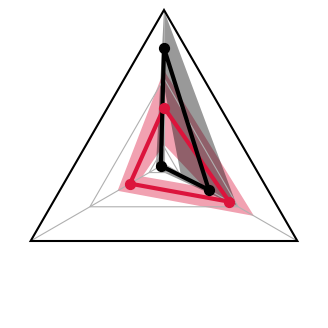

In [56]:


labels = ["Gait", "Akinesia",  "\n Stationary \n movement"]

N = 3
theta = spider_factory.spider_factory(N, frame='polygon')

fig, ax = plt.subplots(figsize=(4,4),
                            subplot_kw=dict(projection='radar'))

zorder = 1
data = stats[(stats["group"]==True) & (stats["condition"]=="baseline")]
spider_factory.plot_spider_single_trace(ax, data, color="crimson", theta=theta)
spider_factory.plot_spider_single_trace(ax, stats[(stats["group"]==False) & (stats["condition"]=="baseline")], color="k", theta=theta)


ax.set_ylim(0, 80)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_rgrids([10, 50, 90])
ax.set_varlabels(["", "", ""])

ax.spines[:].set_linewidth(1.5)


plt.savefig("spider.svg", transparent=True)

In [57]:
ncs.freqs = np.fft.rfftfreq(NFFT, d=1/ncs.fs)

In [58]:
max_freq = 100
min_freq = 5

idx_max = processing.find_closest_index(ncs.freqs, max_freq)
idx_min = processing.find_closest_index(ncs.freqs, min_freq)


In [59]:
df = ncs.plot_prep_psds_dataset(test_sbj_list=pda, condense=True)


/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  psds_means = psds_means.applymap(lambda x: [] if x is None else x)
/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:78: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  psds_means[events_col] = psds_means[events_col].applymap(mean_psds, na_action="ignore")


In [60]:
help(neural_correlates_plot.plot_psd_single_state)

Help on function plot_psd_single_state in module neurokin.utils.experiments.neural_correlates_plot:

plot_psd_single_state(ax, df, group, condition, state, freqs, color, idx_min, idx_max, stat='std', linewidth=3)
    Plots the Power Spectral Denisty trace of a single state, on a given ax.

    :param ax: axis to plot on
    :param group: which subject group to plot
    :param condition: which experimental condition to plot
    :param state: which state to plot
    :param freqs: frequencies corresponding to the full array of PSD values
    :param idx_min: index of the minimum frequency to plot
    :param idx_max: index of the maximum frequency to plot
    :param color: color of the trace
    :param stat: which stat to use to compute the shading, default standard deviation
    :param linewidth: how thick to draw the mean line.
    :return:



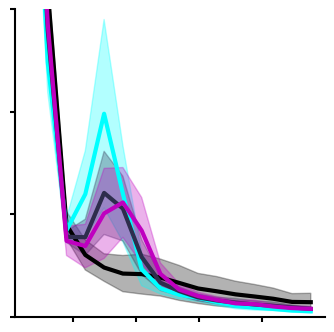

In [61]:
fig, ax = plt.subplots(sharey=True, figsize=(4,4))
colors = ["cyan", "#2e2d4d", "m"]
states = ["event_fog", "event_nlm", "event_gait",]
titles = ["Akinesia", "Stationary \n movement", "Gait"]

neural_correlates_plot.plot_psd_single_state(ax=ax, df=df,  group=False,
                  condition="baseline",
                  state=states[2],
                  freqs=ncs.freqs,
                  color="k",
                  idx_min=idx_min,
                  idx_max=idx_max)

# Plot Parkinson's animals
for i in range(3):
    neural_correlates_plot.plot_psd_single_state(ax=ax, df=df, group=True,
                      condition="baseline",
                      state=states[i],
                      freqs=ncs.freqs,
                      color=colors[i],
                      idx_min=idx_min,
                      idx_max=idx_max)
    ax.set_xlabel("Freqs [Hz]", fontsize=15)
    #ax.set_title(f"{titles[i]}")

# Plot Sham animals

ylim = 18 #zscore

ax.set_ylabel("PSD [AU]", fontsize=15)
ax.set_ylim(0, ylim)

ax.spines[['right', 'top']].set_visible(False)
ax.set_yticks(ax.get_yticks()[::3],labels=[])
ax.set_xticks([20, 40, 60, 80], [])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("psd.svg", transparent=True)

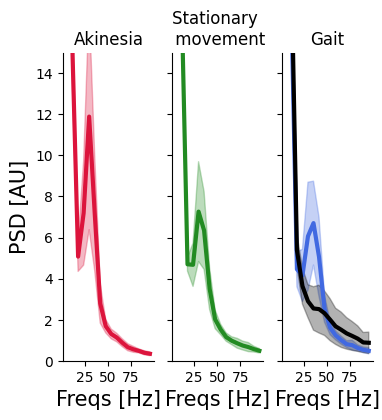

In [62]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(4,4))
colors = ["crimson" ,"forestgreen", "royalblue", ]
states = ["event_fog", "event_nlm", "event_gait",]
titles = ["Akinesia", "Stationary \n movement", "Gait"]


# Plot Parkinson's animals
for i, ax in enumerate(axs):
    neural_correlates_plot.plot_psd_single_state(ax=ax, df=df, group=True,
                      condition="baseline",
                      state=states[i],
                      freqs=ncs.freqs,
                      color=colors[i],
                      idx_min=idx_min,
                      idx_max=idx_max)
    ax.set_xlabel("Freqs [Hz]", fontsize=15)
    ax.set_title(f"{titles[i]}")

# Plot Sham animals

neural_correlates_plot.plot_psd_single_state(ax=ax, df=df,  group=False,
                  condition="baseline",
                  state=states[2],
                  freqs=ncs.freqs,
                  color="k",
                  idx_min=idx_min,
                  idx_max=idx_max)

ylim = 15 #zscore

axs[0].set_ylabel("PSD [AU]", fontsize=15)
ax.set_ylim(0, ylim)
for a in axs:
    a.spines[['right', 'top']].set_visible(False)


In [63]:
def compute_beta_mean(data, idx_min, idx_max):
    try:
        return np.mean(np.asarray(data).mean(axis=0)[idx_min:idx_max])
    except IndexError:
        return None

In [64]:
df = ncs.psds_correlates_dataset.copy()
df = neural_states_helper.condense_distribution_event_types(df)
df["group"] = df["subject"].apply(lambda x: x in pda)
beta_df = pd.DataFrame(columns=states)

In [65]:
df

,date,subject,condition,run,fs,event_gait,group,event_fog,event_nlm
0,230303,NWE00090,baseline,05,24414.0625,"[[11.0558405, 41.547634, 13.567288, 2.9943955,...",False,[],[]
1,230303,NWE00090,baseline,08,24414.0625,"[[10.332631, 38.809982, 20.371641, 2.7916887, ...",False,[],"[[5.35522, 40.883392, 17.144625, 4.5757565, 2...."
2,230303,NWE00090,baseline,11,24414.0625,[],False,"[[11.506811, 39.358433, 18.36227, 4.149787, 1....","[[7.1016417, 41.12669, 13.540928, 8.27383, 4.9..."
3,230303,NWE00090,baseline,04,24414.0625,[],False,"[[4.8080072, 42.206062, 15.01122, 3.158016, 1....","[[2.2291222, 43.36383, 12.151897, 3.2969282, 1..."
4,230303,NWE00090,baseline,01,24414.0625,"[[12.160192, 37.824997, 19.88468, 5.60135, 3.5...",False,[],"[[8.086605, 41.810574, 14.336446, 3.3706305, 2..."
...,...,...,...,...,...,...,...,...,...
179,230504,NWE00166,baseline,09,24414.0625,"[[7.1354585, 36.860806, 22.983803, 5.6150646, ...",False,[],[]
180,230504,NWE00166,baseline,06,24414.0625,"[[6.5587955, 36.63874, 22.977243, 5.5531507, 3...",False,[],[]
181,230504,NWE00166,baseline,03,24414.0625,"[[8.929252, 29.921566, 19.527487, 10.57644, 14...",False,[],[]
182,230504,NWE00166,baseline,10,24414.0625,"[[7.846238, 39.216103, 17.187433, 7.2430763, 4...",False,[],[]


In [66]:
idx_max = processing.find_closest_index(ncs.freqs, 42)
idx_min = processing.find_closest_index(ncs.freqs, 20)


beta_df[states] = df[states].applymap(compute_beta_mean, na_action="ignore", idx_min=idx_min, idx_max=idx_max)
beta_df["group"] = df["group"]
beta_df["subject"]	= df["subject"]
beta_df["run_id"]	= df["date"] + "_" + df["run"]
beta_df = beta_df[beta_df["group"]==True]

/tmp/ipykernel_2913543/1311538584.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  beta_df[states] = df[states].applymap(compute_beta_mean, na_action="ignore", idx_min=idx_min, idx_max=idx_max)
/tmp/ipykernel_2913543/2629789149.py:3: RuntimeWarning: Mean of empty slice.
  return np.mean(np.asarray(data).mean(axis=0)[idx_min:idx_max])
/home/garullie/.conda/envs/cebra/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [67]:
beta_df

,event_fog,event_nlm,event_gait,group,subject,run_id
94,NaN,NaN,5.425326,True,NWE00130,230329_02
95,11.567210,8.194644,NaN,True,NWE00130,230329_08
96,NaN,NaN,6.916062,True,NWE00130,230329_04
97,14.093708,5.577435,NaN,True,NWE00130,230329_09
98,9.145199,7.642158,10.316854,True,NWE00130,230329_06
99,NaN,NaN,4.097747,True,NWE00130,230329_03
100,9.047013,7.832088,NaN,True,NWE00130,230329_07
101,12.048644,3.692308,NaN,True,NWE00130,230330_02
102,NaN,NaN,5.149917,True,NWE00130,230330_05
103,NaN,9.918760,5.846744,True,NWE00130,230330_08


In [68]:

df_long = pd.melt(
    beta_df,
    id_vars=['group', 'subject', 'run_id'],       # columns to keep
    value_vars=['event_fog', 'event_nlm', 'event_gait'],  # columns to melt
    var_name='event_type',                     # new column indicating the event type
    value_name='beta_band_value'               # new column for the melted values
)

# Drop rows where 'beta_band_value' is NaN
df_long = df_long.dropna(subset=['beta_band_value'])
df_long['subject_run'] = df_long['subject'].astype(str) + "_" + df_long['run_id'].astype(str)




In [69]:
beta_df[states] = df[states].applymap(compute_beta_mean, na_action="ignore", idx_min=idx_min, idx_max=idx_max)
beta_df["subject"]	= df["subject"]
beta_df["date"]	= df["date"]
df_long = pd.melt(
    beta_df,
    id_vars=['subject', "date"],       # columns to keep
    value_vars=['event_fog', 'event_nlm', 'event_gait'],  # columns to melt
    var_name='event_type',                     # new column indicating the event type
    value_name='beta_band_value'               # new column for the melted values
)
df_long = df_long.dropna(subset=['beta_band_value'])
df_long.to_csv("df_long_pd.csv", index=False)

/tmp/ipykernel_2913543/2315266505.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  beta_df[states] = df[states].applymap(compute_beta_mean, na_action="ignore", idx_min=idx_min, idx_max=idx_max)
/tmp/ipykernel_2913543/2629789149.py:3: RuntimeWarning: Mean of empty slice.
  return np.mean(np.asarray(data).mean(axis=0)[idx_min:idx_max])
/home/garullie/.conda/envs/cebra/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [70]:
df_long[df_long["subject"]=="NWE00161"]

,subject,date,event_type,beta_band_value
25,NWE00161,230425,event_fog,9.230685
26,NWE00161,230425,event_fog,9.635169
27,NWE00161,230425,event_fog,2.339610
28,NWE00161,230425,event_fog,15.153765
30,NWE00161,230425,event_fog,10.564937
31,NWE00161,230425,event_fog,12.896564
34,NWE00161,230425,event_fog,11.648424
85,NWE00161,230425,event_nlm,8.083685
86,NWE00161,230425,event_nlm,9.093198
87,NWE00161,230425,event_nlm,6.617265


## Model in R

Modelling the intercept only given the subject and the date nested in the subject

model <- lmer(
  beta_band_value ~ event_type + (1 | subject),
  data = df_long
)

In [71]:
model = pd.read_csv("./model_fixed_effects.csv")
model = pd.read_csv("./model_fixed_effects_sbj.csv")
df_long = pd.read_csv("df_long_pd.csv")

In [72]:
coefs = model.copy()

In [73]:
coefs

,effect,term,estimate,std.error,statistic,conf.low,conf.high
0,fixed,(Intercept),7.668695,0.820235,9.349391,6.061065,9.276326
1,fixed,event_typeevent_gait,-2.476921,0.495372,-5.000127,-3.447831,-1.506010
2,fixed,event_typeevent_nlm,-2.073451,0.472717,-4.386243,-2.999959,-1.146943


/tmp/ipykernel_2913543/67326461.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="estimate", y="term", data=coefs, join=False, color="black", marker="o")


KeyError: 'p.value'

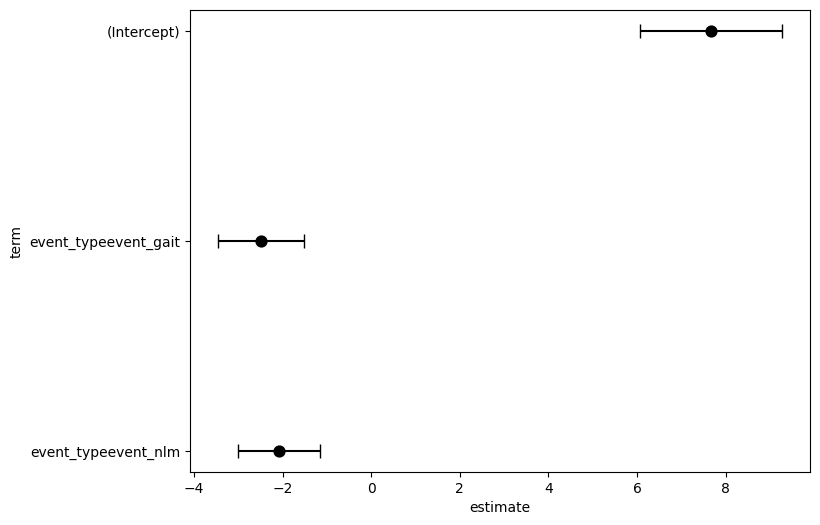

In [74]:
plt.figure(figsize=(8, 6))
sns.pointplot(x="estimate", y="term", data=coefs, join=False, color="black", marker="o")
plt.errorbar(
    coefs["estimate"],
    coefs["term"],
    xerr=[
        coefs["estimate"] - coefs["conf.low"],  # Lower error
        coefs["conf.high"] - coefs["estimate"]  # Upper error
    ],
    fmt="none",
    c="black",
    capsize=5,
)

# Highlight significance thresholds
for idx, row in coefs.iterrows():
    significance = "NS" if row["p.value"] > 0.05 else "***" if row["p.value"] < 0.001 else "**" if row["p.value"] < 0.01 else "*"
    plt.text(row["estimate"], row["term"], f"  {significance}", va="center", ha="left")

plt.axvline(0, color="gray", linestyle="--")  # Zero line
plt.title("Fixed Effects Estimates with 95% CIs")
plt.xlabel("Estimate")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

In [78]:
model["mean"] = model["estimate"]
model["yerr_low"] = model["conf.low"]
model["yerr_high"] = model["conf.high"]
intercept = model.loc[model["term"] == "(Intercept)", "estimate"].values[0]
model.loc[model["term"] != "(Intercept)", "yerr_low"] = (intercept + model.loc[model["term"] != "(Intercept)", "conf.low"])
model.loc[model["term"] != "(Intercept)", "yerr_high"] = (intercept + model.loc[model["term"] != "(Intercept)", "conf.high"])
model.loc[model["term"] != "(Intercept)", "mean"] = (intercept + model.loc[model["term"] != "(Intercept)", "estimate"])
model["event_type"] = ["Akinesia", "Gait", "Statioanry Movement"]

In [79]:
model

,effect,term,estimate,std.error,statistic,conf.low,conf.high,mean,yerr_low,yerr_high,event_type
0,fixed,(Intercept),7.668695,0.820235,9.349391,6.061065,9.276326,7.668695,6.061065,9.276326,Akinesia
1,fixed,event_typeevent_gait,-2.476921,0.495372,-5.000127,-3.447831,-1.506010,5.191775,4.220865,6.162685,Gait
2,fixed,event_typeevent_nlm,-2.073451,0.472717,-4.386243,-2.999959,-1.146943,5.595245,4.668737,6.521753,Statioanry Movement


In [80]:
pairwise = pd.read_csv("./pairwise_comparisons.csv")
pairwise = pd.read_csv("./pairwise_comparisons_sbj.csv")

In [81]:
pairwise

,contrast,estimate,SE,df,z.ratio,p.value
0,event_fog - event_gait,2.476921,0.495372,inf,5.000127,0.000002
1,event_fog - event_nlm,2.073451,0.472717,inf,4.386243,0.000034
2,event_gait - event_nlm,-0.403470,0.456429,inf,-0.883970,0.650440


In [82]:
events = ["event_fog", "event_nlm", "event_gait"]
combos = [[0,1], [0,2], [2,1]]
colors = ["cyan", "#2e2d4d", "m"]

In [94]:
np.unique(df_long.event_type)

array(['event_fog', 'event_gait', 'event_nlm'], dtype=object)

In [95]:
# Add jitter to the x-axis (categories)
jitter = 0.5 * (np.random.rand(len(df_long["beta_band_value"])) - 0.5)  # Adjust the scale of jitter
df_long["category_jittered"] = df_long["event_type"].map({"event_fog": 0, "event_nlm": 1, "event_gait": 2}) + jitter

(0.0, 18.0)


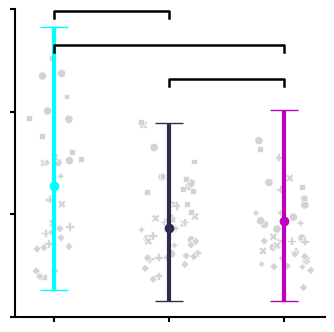

In [96]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(x="category_jittered", y="beta_band_value", data=df_long, style="subject", zorder=0, ax=ax, color="lightgray", )
font = 15

#Model predictions with error bars

for i in range(3):
    yerr = np.array([[model.loc[i, "yerr_low"]], [model.loc[i, "yerr_high"]]])
    ax.errorbar(x=i, y=model.loc[i, "mean"], yerr=yerr, 
            fmt="o", color=colors[i], label="Model Predictions", capsize=10, linewidth=3)


y = 17.5
for combo in combos:
    x1, x2 = combo[0], combo[1]
    contrast = f"{events[x1]} - {events[x2]}"
    pval = pairwise.loc[pairwise["contrast"]==contrast,"p.value"]
    pval = pval.values[0]
    #p = " " if pval > 0.05 else "***" if pval < 0.001 else "**" if pval < 0.01 else "*"
    p = ""
    h, col = 0.4, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.8, c=col)
    ax.text((x1+x2)*.5, y-h/9,  f"{p}", ha='center', va='bottom', color=col, fontsize=font)
    y-=2

ax.set_ylim(0, 18)
ax.get_legend().remove()
ax.set_xticks([0, 1, 2], labels=[])
ax.set_yticks(ax.get_yticks()[::3], labels=[])
#ax.set_xlabel("Event Type")
#ax.set_ylabel("Beta Band Value")
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

print(ax.get_ylim())
plt.savefig("linear_model.svg", transparent=True)

In [ ]:
model

In [64]:
pairwise

,event_type,contrast,emmean,SE,df,asymp.LCL,asymp.UCL
0,event_fog,.,7.668695,0.820235,inf,5.504705,9.832686
1,event_gait,.,5.191775,0.806007,inf,3.065320,7.318230
2,event_nlm,.,5.595245,0.796237,inf,3.494566,7.695923
3,.,event_fog - event_gait,2.476921,0.495372,inf,1.170003,3.783838
4,.,event_fog - event_nlm,2.073451,0.472717,inf,0.826302,3.320600
5,.,event_gait - event_nlm,-0.403470,0.456429,inf,-1.607647,0.800708
